In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gurobipy as gp
from gurobipy import GRB
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable   # For advanced plotting
from matplotlib.ticker import MaxNLocator

### Step 1: Loading the dataset
#### The dataset contains price and demand data which will be used for regression analysis and optimization.


In [58]:
data = pd.read_csv('price_demand_data.csv')

In [60]:
data.head()

,price,demand
0,1.05,283
1,0.86,771
2,1.21,185
3,0.94,531
4,0.76,1002


### Step 2: Visualizing the relationship between price and demand

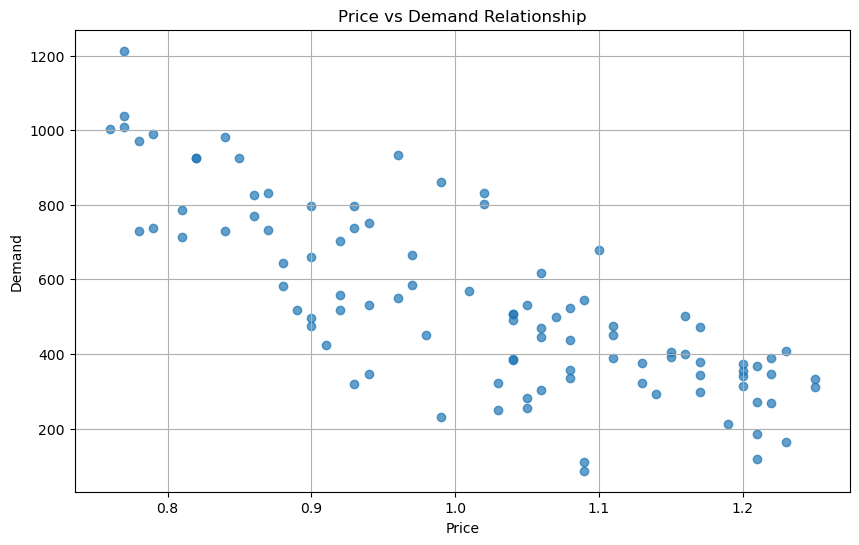

In [63]:
if 'price' in data.columns and 'demand' in data.columns:
    
    # Plotting the relationship between Price and Demand
    plt.figure(figsize=(10, 6))
    plt.scatter(data['price'], data['demand'], alpha=0.7)
    plt.title("Price vs Demand Relationship")
    plt.xlabel("Price")
    plt.ylabel("Demand")
    plt.grid(True)
    plt.show()
else:
    print("The dataset does not contain 'Price' and 'Demand' columns.")

### Step 3: Grouping data into price bins and calculating average demand

C:\Users\manas\AppData\Local\Temp\ipykernel_41148\243675605.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('Price_Bin').agg(Avg_Demand=('demand', 'mean')).reset_index()


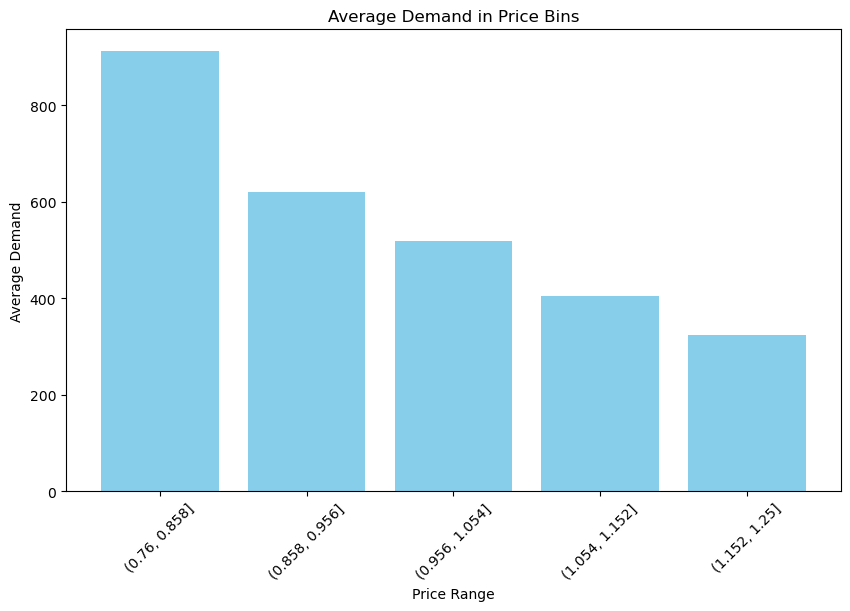

In [66]:
# Creating bins for price ranges
data['Price_Bin'] = pd.cut(data['price'], bins=5)   # Dividing prices into 5 bins

# Aggregating average demand for each bin
grouped = data.groupby('Price_Bin').agg(Avg_Demand=('demand', 'mean')).reset_index()

# Bar plot to visualize average demand in different price bins
plt.figure(figsize=(10, 6))
plt.bar(grouped['Price_Bin'].astype(str), grouped['Avg_Demand'], color='skyblue')
plt.title("Average Demand in Price Bins")
plt.xlabel("Price Range")
plt.ylabel("Average Demand")
plt.xticks(rotation=45)
# plt.grid(axis='y')
plt.show()


### Step 4: Calculating revenue and grouping data by price bins for cumulative revenue

C:\Users\manas\AppData\Local\Temp\ipykernel_41148\838161014.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_grouped = data.groupby('Price_Bin').agg(Cumulative_Revenue=('Revenue', 'sum')).reset_index()


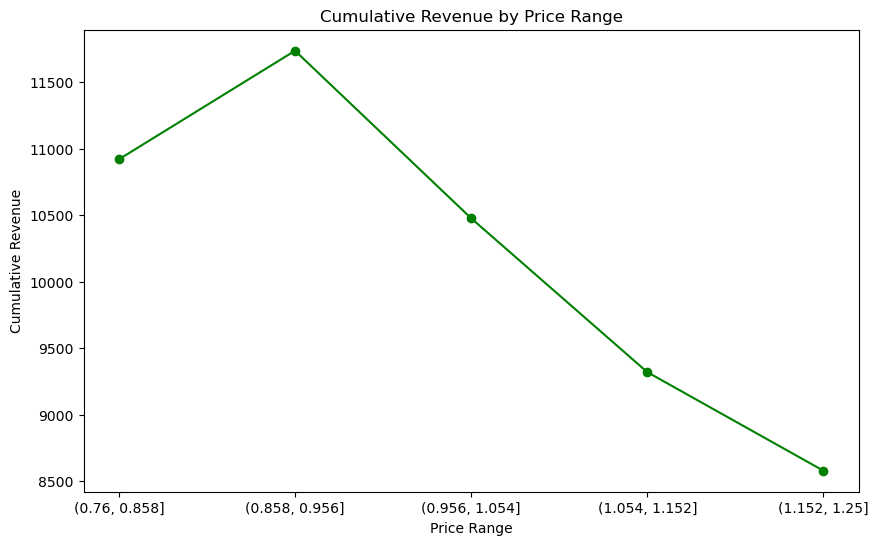

In [69]:
data['Revenue'] = data['price'] * data['demand']
data['Price_Bin'] = pd.cut(data['price'], bins=5)  # Adjust bins as needed

# Aggregating cumulative revenue for each price bin
revenue_grouped = data.groupby('Price_Bin').agg(Cumulative_Revenue=('Revenue', 'sum')).reset_index()

# Line plot to visualize cumulative revenue across price bins
plt.figure(figsize=(10, 6))
plt.plot(revenue_grouped['Price_Bin'].astype(str), revenue_grouped['Cumulative_Revenue'], marker='o', color='green', linestyle='-')
plt.title("Cumulative Revenue by Price Range")
plt.xlabel("Price Range")
plt.ylabel("Cumulative Revenue")
# plt.xticks(rotation=45)
plt.show()


### Step 5: Fitting a linear regression model to the data

In [72]:
X = data['price'].values.reshape(-1,1)  # Independent variable (price)
y = data['demand'].values  # Dependent variable (demand)

In [74]:
# Creating and fitting the model
model = LinearRegression()

model.fit(X,y)

# Extracting coefficients
beta_0 = model.intercept_  # Intercept of the model
beta_1 = model.coef_[0]    # Slope of the model

print(f"Fitted Model: Demand = {beta_0:.2f} + {beta_1:.2f} * Price")


Fitted Model: Demand = 1924.72 + -1367.71 * Price


### Step 6: Calculating residuals from the fitted model

In [77]:
# Calculate and store residuals
residuals = y - model.predict(X)

### Step 7

### Step 7.1: Estimating demand for a specific price

In [81]:
# Estimate Demand based on Price Assumption
p = 1
estimated_demand = [beta_0 + beta_1*p + res for res in residuals]

#### Step 7.2 : Solving for optimal quantity using LP and basic NVM model with price = 1

In [84]:
# Solve for optimal Quantity when price=1 using estimated demand using gurobi
from gurobipy import GRB, quicksum
  
n = len(estimated_demand)

# Defining constants
c = 0.5    # Cost of manufacturing


# Initializing the linear programming model
lp_model_basic = gp.Model('NVM_basic')

# Adding variables
q = lp_model_basic.addVar(lb = 0, name = 'q')     # Quantity to produce
h = lp_model_basic.addVars(n, lb= -GRB.INFINITY, name = 'h') # Daily profit

# Objective: Maximize average profit
lp_model_basic.setObjective(quicksum(h[i] for i in range(n))/n, GRB.MAXIMIZE)

# Adding constraints for profit calculation
a = lp_model_basic.addVars(n, lb = 0, name = 'a')

for i in range(n):
    lp_model_basic.addConstr(a[i] <= q )
    lp_model_basic.addConstr(a[i] <= estimated_demand[i])
    lp_model_basic.addConstr(h[i] <= p*a[i] - c*q )


# Optimizing the model
lp_model_basic.optimize()

# Tell Gurobi to shutup!
lp_model_basic.Params.OutputFlag = 0 


# Extracting and displaying results
if lp_model_basic.status == GRB.OPTIMAL:
    optimal_q = q.X
    print(f"Optimal Quantity to Produce (p = 1): {optimal_q}")
else:
    print("No optimal solution found.")
    

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 297 rows, 199 columns and 594 nonzeros
Model fingerprint: 0x611dcb3d
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 9e+02]
Presolve removed 198 rows and 99 columns
Presolve time: 0.01s
Presolved: 99 rows, 100 columns, 198 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.8326835e+02   8.085644e+02   0.000000e+00      0s
      48    2.1928317e+02   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.192831655e+02
Optimal Quantity to Produce (p = 1): 569.8967553157715


### Step 8: Solving for optimal quantity using Linear Programming

#### Optimal Quantity when Price = 1

In [88]:
# Solve for optimal Quantity when price=1 using estimated demand using gurobi
from gurobipy import GRB, quicksum

# Defining constants
c = 0.5    # Cost of manufacturing
g = 0.75   # Cost of rush order
t = 0.15   # Disposal cost
  
n = len(estimated_demand)

# Initializing the linear programming model
lp_model = gp.Model('NVM_1')

# Adding variables
q = lp_model.addVar(lb = 0, name = 'q')     # Quantity to produce
h = lp_model.addVars(n, lb= -GRB.INFINITY, name = 'h') # Daily profit

# Objective: Maximize average profit
lp_model.setObjective(quicksum(h[i] for i in range(n))/n, GRB.MAXIMIZE)

# Adding constraints for profit calculation
a = lp_model.addVars(n, lb = 0, name = 'a')
b = lp_model.addVars(n, lb = 0, name = 'b')

for i in range(n):
    lp_model.addConstr(a[i] >= 0)
    lp_model.addConstr(a[i] >= estimated_demand[i] - q)
    lp_model.addConstr(b[i] >= 0)
    lp_model.addConstr(b[i] >= q - estimated_demand[i])
    lp_model.addConstr(h[i] <= p*estimated_demand[i] - c*q - g*a[i] - t*b[i])


# Optimizing the model
lp_model.optimize()

# Tell Gurobi to shutup!
lp_model.Params.OutputFlag = 0 


# Extracting and displaying results
if lp_model.status == GRB.OPTIMAL:
    optimal_q = q.X
    print(f"Optimal Quantity to Produce (p = 1): {optimal_q}")
else:
    print("No optimal solution found.")
    

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 495 rows, 298 columns and 990 nonzeros
Model fingerprint: 0x76df0f84
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 9e+02]
Presolve removed 297 rows and 99 columns
Presolve time: 0.01s
Presolved: 198 rows, 199 columns, 396 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5700502e+02   5.514350e+04   0.000000e+00      0s
      99    2.3148367e+02   0.000000e+00   0.000000e+00      0s

Solved in 99 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.314836666e+02
Optimal Quantity to Produce (p = 1): 471.86537959089355


### Step 9: Solving for optimal price and quantity using Quadratic Programming (QP)

#### Optimizing for Demand Quantity and Price simultaneously

In [92]:
# Solve for optimal Quantity when price=1 using estimated demand using gurobi
from gurobipy import GRB, quicksum

# Defining constants
c = 0.5   # Cost of manufacturing
g = 0.75  # Cost of rush order
t = 0.15  # Disposal cost

n = len(estimated_demand)   # Number of data points (days)


# Initializing the quadratic programming model
qp_model = gp.Model('NVM_1')


# Adding variables
q = qp_model.addVar(lb=0, name='q')  # Quantity to produce
p = qp_model.addVar(lb=0, name='p')  # Price of the product
h = qp_model.addVars(n, lb=-GRB.INFINITY, name='h')  # Daily profit
a = qp_model.addVars(n, lb=0, name='a')  # Cost of rush orders
b = qp_model.addVars(n, lb=0, name='b')  # Disposal costs

# Estimating demand as a function of price
# Using the fitted linear regression model with residuals
demand = [beta_0 + beta_1 * p + res for res in residuals]


# Objective: Maximize the average profit
# Profit is calculated as revenue (p * demand) minus costs (manufacturing, rush, disposal)
qp_model.setObjective(quicksum(h[i] for i in range(n)) / n, GRB.MAXIMIZE)


# Adding constraints for profit calculation
for i in range(n):
    # Ensure non-negative rush order and disposal costs
    qp_model.addConstr(a[i] >= 0)
    qp_model.addConstr(a[i] >= demand[i] - q)  # Rush cost occurs when demand exceeds production
    qp_model.addConstr(b[i] >= 0)
    qp_model.addConstr(b[i] >= q - demand[i])  # Disposal cost occurs when production exceeds demand
    
    # Profit constraints
    qp_model.addConstr(h[i] <= p * demand[i] - c * q - g * a[i] - t * b[i])

# Optimizing the quadratic program
qp_model.optimize()

# Tell Gurobi to shut up!
qp_model.Params.OutputFlag = 0 


# Extracting and displaying results
if qp_model.status == GRB.OPTIMAL:
    optimal_q = q.X  # Optimal quantity
    optimal_p = p.X  # Optimal price
    print(f"Optimal Quantity: {optimal_q}, Optimal Price: {optimal_p}")
else:
    print("No optimal solution found.")

    

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 396 rows, 299 columns and 792 nonzeros
Model fingerprint: 0x789850f9
Model has 99 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  QMatrix range    [1e+03, 1e+03]
  QLMatrix range   [1e-01, 2e+03]
  Objective range  [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Presolve removed 198 rows and 0 columns
Presolve time: 0.01s
Presolved: 495 rows, 595 columns, 1583 nonzeros
Presolved model has 99 second-order cone constraints
Ordering time: 0.01s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 7.880e+04
 Factor NZ  : 7.930e+04 (roughly 1 MB of memory)
 Factor Ops : 2.094e+07 (less than 1 second per iteration)
 Threads    : 14

                  Objective    

### Step 10: Bootstrapping to analyze sensitivity of optimal price and quantity

#### Sensitivity Analysis Using Bootstrapped Samples

In [96]:
# This section performs multiple iterations of the optimization process with bootstrapped data

bootstrapped_quantities = []
bootstrapped_prices = []
bootstrapped_profits = []

for _ in range(100):  # Number of bootstrap samples
    # Randomly sample data points with replacement
    sample_indices = np.random.choice(range(n), size=n, replace=True)
    sampled_X = X[sample_indices]  # Sampled independent variable (price)
    sampled_y = y[sample_indices]  # Sampled dependent variable (demand)


    # Fitting a new linear regression model to the bootstrapped dataset
    model = LinearRegression()
    model.fit(sampled_X, sampled_y)
    beta_0_new = model.intercept_  # New intercept
    beta_1_new = model.coef_[0]    # New slope

    # Calculating residuals for the bootstrapped dataset
    residuals = sampled_y - model.predict(sampled_X)

    # Defining constants
    c = 0.5   # Cost of manufacturing
    g = 0.75  # Cost of rush order
    t = 0.15  # Disposal cost
    
    n = len(demand)
    
    # Re-initialize the QP model for the bootstrapped dataset
    qp_model = gp.Model('NVM_5')
    
    # Redefine variables for the new optimization
    q = qp_model.addVar(lb = 0, name = 'q')
    p = qp_model.addVar(lb = 0, name = 'p')
    h = qp_model.addVars(n, lb= -GRB.INFINITY, name = 'h')
    
    #z = lp_model.addVars(n, lb=0, name = 'z') # minimum of q and generated_demand[i]
    
    a = qp_model.addVars(n, lb = 0, name = 'a')
    b = qp_model.addVars(n, lb = 0, name = 'b')

    # Estimating demand as a function of price
    # Using the fitted linear regression model with residuals
    demand = [beta_0_new + beta_1_new * p + res for res in residuals]
    
    # Setting the objective for the bootstrapped dataset
    qp_model.setObjective(quicksum(h[i] for i in range(n))/n, GRB.MAXIMIZE)
    
    # Adding constraints based on the bootstrapped demand data
    for i in range(n):
        #lp_model.addConstr(z[i] <= q)
        #lp_model.addConstr(z[i] <= estimated_demand[i])
        qp_model.addConstr(a[i] >= 0)
        qp_model.addConstr(a[i] >= demand[i] - q)
        qp_model.addConstr(b[i] >= 0)
        qp_model.addConstr(b[i] >= q - demand[i])
        qp_model.addConstr(h[i] <= p*demand[i] - c*q - g*a[i] - t*b[i])

    # Tell Gurobi to shutup!
    qp_model.Params.OutputFlag = 0
    
    # Optimizing the QP model for the bootstrapped data
    qp_model.optimize()
    
    # Storing the results if the solution is optimal
    if qp_model.status == GRB.OPTIMAL:
        bootstrapped_quantities.append(q.X)
        bootstrapped_prices.append(p.X)
        bootstrapped_profits.append(qp_model.objVal)


### Step 11: Visualizing results of bootstrapping

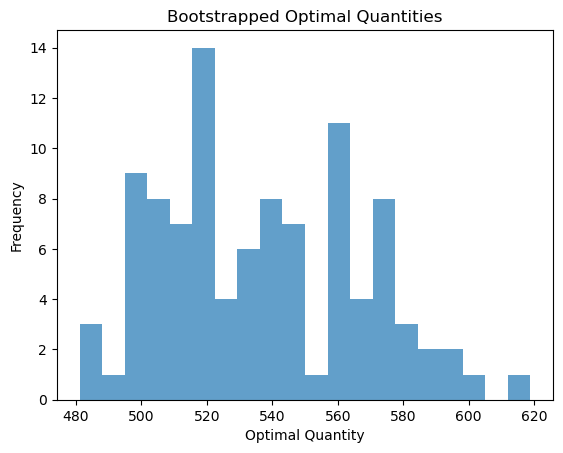

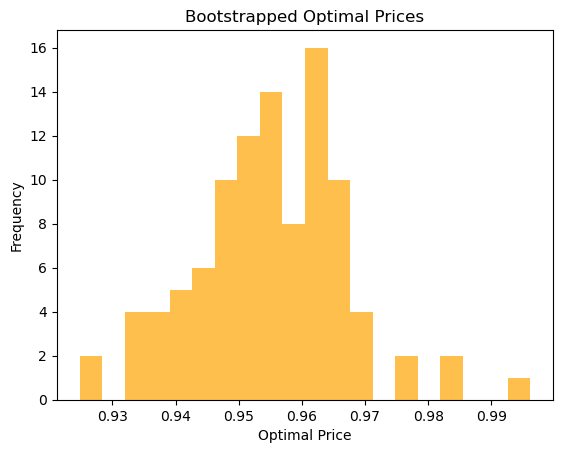

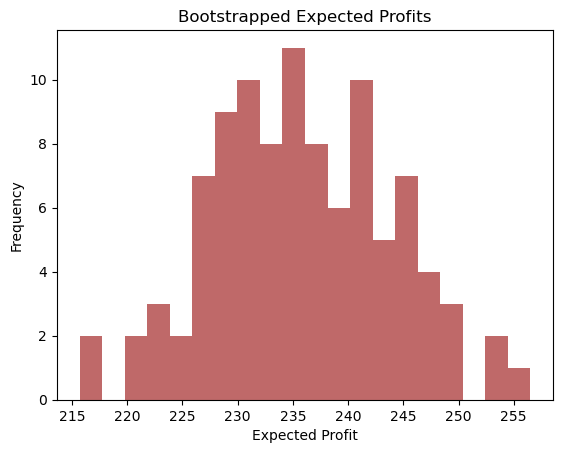

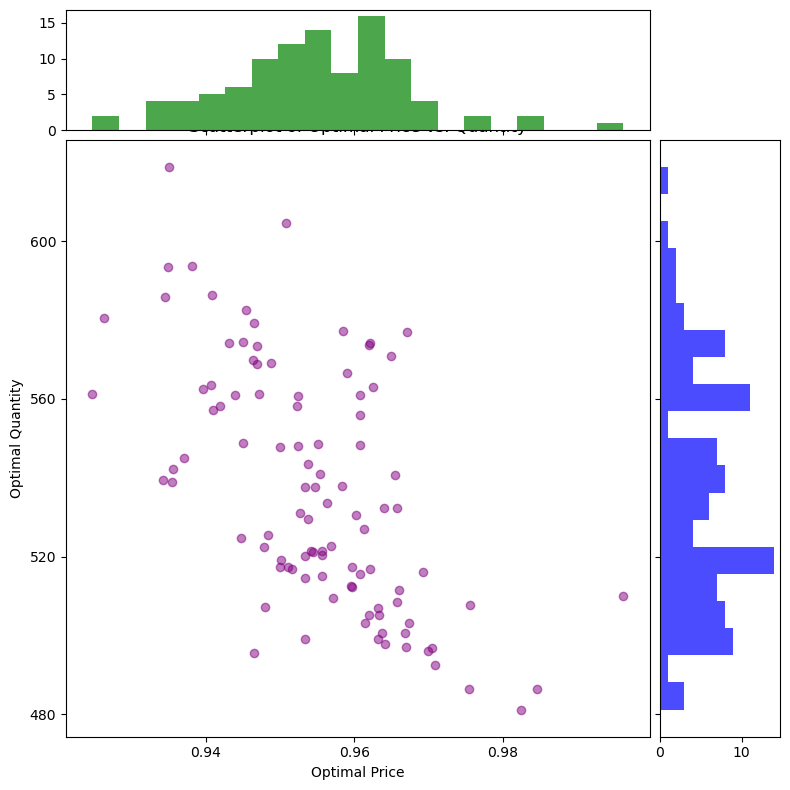

In [98]:

# Histogram for bootstrapped quantities
plt.hist(bootstrapped_quantities, bins=20, alpha=0.7)
plt.xlabel('Optimal Quantity')
plt.ylabel('Frequency')
plt.title('Bootstrapped Optimal Quantities')
plt.show()

# Histogram for bootstrapped prices
plt.hist(bootstrapped_prices, bins=20, alpha=0.7, color='orange')  # Use a different color for clarity
plt.xlabel('Optimal Price')
plt.ylabel('Frequency')
plt.title('Bootstrapped Optimal Prices')
plt.show()

# Histogram for bootstrapped prices
plt.hist(bootstrapped_profits, bins=20, alpha=0.7, color='brown')  # Use a different color for clarity
plt.xlabel('Expected Profit')
plt.ylabel('Frequency')
plt.title('Bootstrapped Expected Profits')
plt.show()

# Scatter plot with histograms: Optimal price vs. quantity
fig, ax = plt.subplots(figsize=(8, 8))


ax.scatter(
    bootstrapped_prices, 
    bootstrapped_quantities, 
    alpha=0.5, color="purple"
)
ax.set_title("Scatterplot of Optimal Price vs. Quantity")
ax.set_xlabel("Optimal Price")
ax.set_ylabel("Optimal Quantity")

# Create histograms on axes
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)

ax_histx.hist(bootstrapped_prices, bins=20, alpha=0.7, color="green")
ax_histy.hist(bootstrapped_quantities, bins=20, alpha=0.7, color="blue", orientation='horizontal')

# Formatting histograms
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

ax_histx.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))
ax_histy.yaxis.set_major_locator(MaxNLocator(nbins=5, prune='both'))

# Display the scatter plot with histograms
plt.tight_layout()
plt.show()
